In [718]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate
from typing import Callable

Рассматривается двухточечная краевая задача

$\displaystyle -\frac{d}{dx}\left(p(x)\frac{du}{dx} \right) + q(x)u = f(x)$

$u(a) = 0, \quad u(b) = 0$

In [719]:
N = 10
K = 94

a = np.floor(np.pi*(N+10))
b = a + K/50 + 2
a, b

(np.float64(62.0), np.float64(65.88))

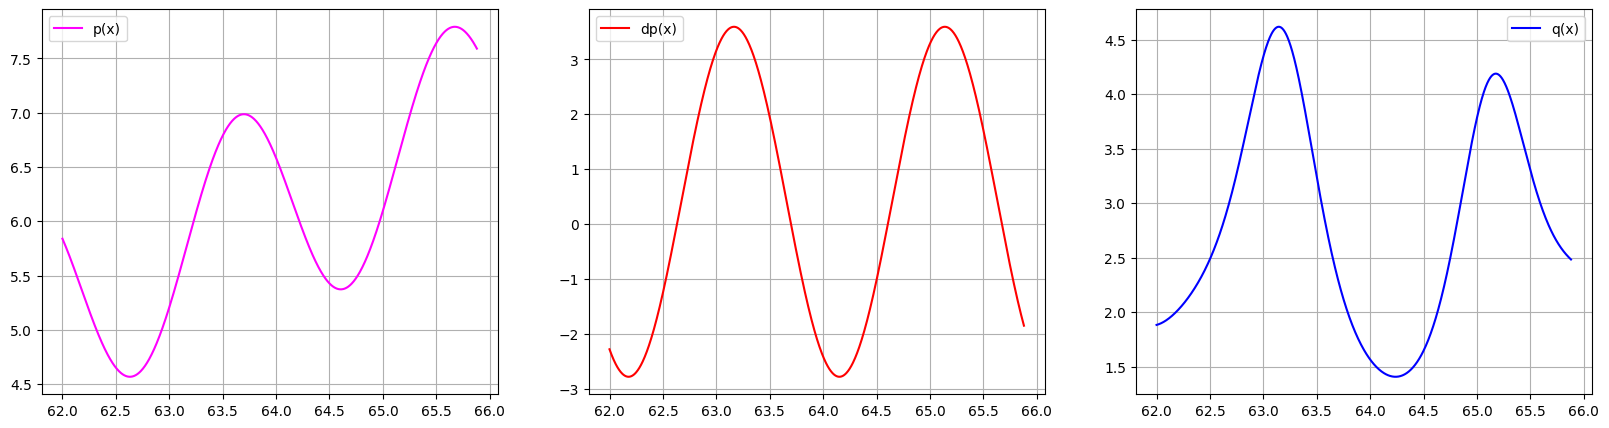

In [720]:
p = lambda x: np.sin(N*x/np.pi) + np.cos(2*N)*x - 20

q = lambda x: np.exp(np.cos(N*x/np.pi)) + np.power(np.cos(N*x/10), 2) + 1

dp = lambda x: N/np.pi*np.cos(N*x/np.pi) + np.cos(2*N)

func = np.array([p, dp, q])
name = np.array(['p', 'dp', 'q'])
col = np.array(['fuchsia', 'red', 'blue'])

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
x = np.linspace(a, b, 1000)

for i in range(axs.size):
    axs[i].plot(x, func[i](x), label=name[i]+'(x)', color = col[i])
    axs[i].grid()
    axs[i].legend()
plt.show()

#### Составьте нетривиальный физически осмысленный тестовый пример.
$u(x)$ должна быть не отрицательной на отрезке $[a, b]$ и такой, что $u(a)=u(b)=0$

$\displaystyle u = -\cosh{\left(x-a-\frac{b-a}{2}\right)}+\cosh{\left(-\frac{b-a}{2} \right)} \implies \frac{du}{dx} = -\sinh{\left(x-a-\frac{b-a}{2}\right)} \implies \frac{d^2u}{dx^2} = -\cosh{\left(x-a-\frac{b-a}{2}\right)}$

Вычислим функцию $f(x)$

$\displaystyle f(x) = -\frac{dp}{dx}\frac{du}{dx} - p\frac{d^2u}{dx^2} + qu$

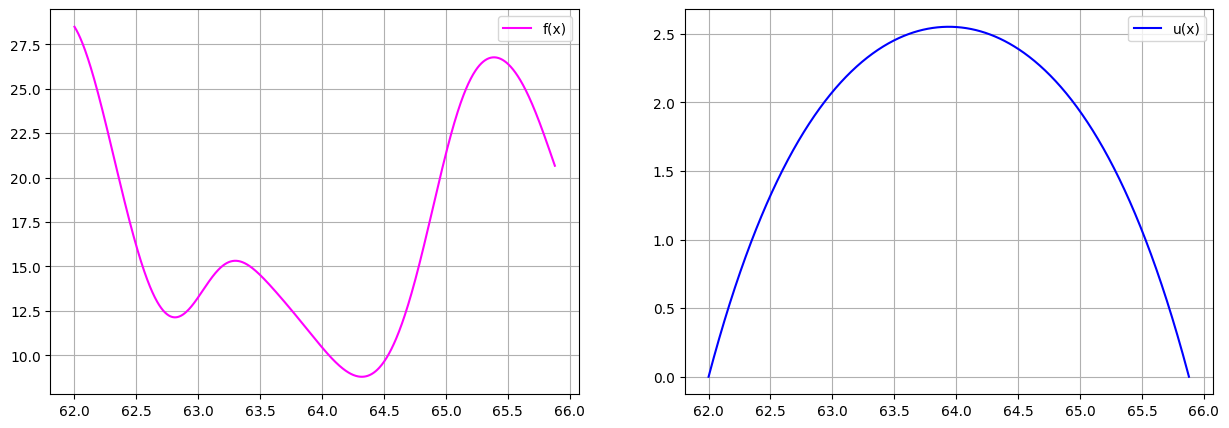

In [721]:
aver = a + (b-a)/2

u = lambda x: -np.cosh(x - aver) + np.cosh(a - aver)

du = lambda x: -np.sinh(x - aver)

ddu = lambda x: -np.cosh(x - aver)

f = lambda x: -dp(x)*du(x) - p(x)*ddu(x) + q(x)*u(x)

func = np.array([f, u])
name = np.array(['f', 'u'])

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
x = np.linspace(a, b, 1000)

for i in range(axs.size):
    axs[i].plot(x, func[i](x), label=name[i]+'(x)', color=col[-i])
    axs[i].legend()
    axs[i].grid()

plt.show()

#### Напишите функцию, генерирующую матрицу системы МКЭ и вектор правой части в зависимости от шага $h$.

In [722]:
def integr(f: Callable[[np.float64], np.float64], x1:np.float64, x2:np.float64)->np.float64:
    return integrate.quad(f, x1, x2)[0]

def simpson(f: Callable[[np.float64], np.float64], x1: np.float64, x2: np.float64, h: np.float64)->np.float64:
    n: np.int64 = int((x2-x1)/h)
    h: np.float64 = (x2-x1)/n
    help = lambda l, r: (r - l)/6.0 * (f(l) + 4.0*f((l+r)/2) + f(r))
    return sum(help(x1+i*h, x1+(i+1)*h) for i in range(n))

def createPhi(x: np.ndarray, h: np.float64, i: int)->Callable[[np.float64], np.float64]:
    h_nr: np.float64 = h*np.sqrt(h)
    if i == 0:
        return lambda t: (x[1] - t)/h_nr if t <= x[1] else 0.0
    if i == x.size - 1:
        return lambda t: (t - x[-2])/h_nr if t >= x[-2] else 0.0
    else:
        def _phi(t):
            if t >= x[i-1] and t <= x[i]:
                return (t - x[i-1])/h_nr
            elif t >= x[i] and t <= x[i+1]:
                return (x[i+1] - t)/h_nr
            else: return 0.0
        return _phi
    
def Phi(x: np.ndarray,h: np.float64)->np.ndarray:
    phi: list = [None] * x.size
    for i in range(x.size):
        phi[i] = createPhi(x, h, i)
    return phi

def createMtrVect(n: np.float64, meth:str='')->tuple[np.ndarray, np.ndarray]:
        x, h = np.linspace(a, b, n, retstep=True)
        h3: np.float64 = 1.0/np.power(h, 3)
        A: np.ndarray = np.zeros((n-2, n-2))
        v: np.ndarray = np.zeros(n-2)
        hn: np.float64 = 1.0/np.sqrt(h)

        phi = Phi(x, h)

        diag: np.ndarray = np.zeros(n-2)
        aboveDiag: np.ndarray = np.zeros(n-2)
        belowDiag: np.ndarray = np.zeros(n-2)

        if meth=='simp':
            for i in range(n-2):
                func = lambda x: h3*p(x) + q(x)*np.power(phi[i+1](x), 2)
                diag[i] = simpson(func, x[i], x[i+2], h/10)

                if i + 1 <= n - 3:
                    func = lambda x: q(x)*phi[i+1](x)*phi[i+2](x) - h3*p(x)
                    aboveDiag[i] = simpson(func, x[i+1], x[i+2], h/10)

                if i - 1 >= 0:
                    func = lambda x: q(x)*phi[i](x)*phi[i+1](x) - h3*p(x)
                    belowDiag[i] = simpson(func, x[i], x[i+1], h/10)

                func = lambda t: f(t) * phi[i+1](t)
                v[i] = hn*simpson(func, x[i], x[i+2], h/10)

        else:
            for i in range(n-2):
                func = lambda x: h3*p(x) + q(x)*np.power(phi[i+1](x), 2)
                diag[i] = integr(func, x[i], x[i+2])

                if i + 1 <= n - 3:
                    func = lambda x: q(x)*phi[i+1](x)*phi[i+2](x) - h3*p(x)
                    aboveDiag[i] = integr(func, x[i+1], x[i+2])

                if i - 1 >= 0:
                    func = lambda x: q(x)*phi[i](x)*phi[i+1](x) - h3*p(x)
                    belowDiag[i] = integr(func, x[i], x[i+1])

                func = lambda t: f(t) * phi[i+1](t)
                v[i] = hn*integr(func, x[i], x[i+2])

        np.fill_diagonal(A[:, 1:], aboveDiag[:-1])
        np.fill_diagonal(A, diag)
        np.fill_diagonal(A[1:, :], belowDiag[1:])
            
        return A, v




#### Проверьте работоспособность метода.

Норма разности: 0.00012938113881279885


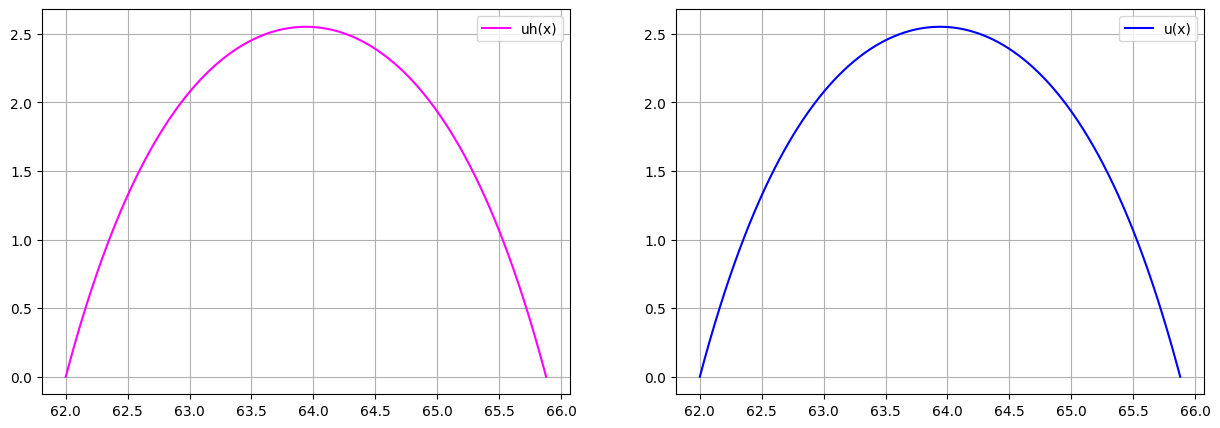

In [723]:
h = 0.01
n = int((b-a)/h)

A, c = createMtrVect(n)

alpha = [u(a)] + list(np.linalg.solve(A, c)) + [u(b)]

x = np.linspace(a, b, n)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].plot(x, alpha, color='fuchsia', label='uh(x)')
axs[1].plot(x, u(x), color='blue', label='u(x)')

for i in range(axs.size):
    axs[i].grid()
    axs[i].legend()

print(f'Норма разности: {np.linalg.norm(u(x)-alpha, ord=2)}')

#### Решите систему методом сопряжённых градиентов с точностью $10^{-10}$ для шага $h = 10^{-1}, 20^{-1}, 30^{-1}, . . . , 500^{-1}$.

##### Алгоритм CG

Начальные данные\
$\qquad x^0$\
$\qquad r^0 = b - Ax^0$\
$\qquad z^0 = r^0$\
$i$-ая итерация\
$\qquad w^{i} = Az^{i-1}$\
$\qquad q_{i} = (r^{i-1}, r^{i-1})$\
$\qquad \displaystyle a_i = \frac{q_{i}}{(w^{i}, z^{i-1})}$\
$\qquad x^i = x^{i-1} + a_iz^{i-1}$\
$\qquad r^i = r^{i-1} - a_iw^{i}$\
$\qquad \displaystyle \beta_i = \frac{(r^{i}, r^{i})}{q_{i}}$\
$\qquad z^i = r^i + \beta_iz^{i-1}$\
Критерий остановки\
$\qquad ||r^i||_2 < error$

In [724]:
hArr:np.ndarray = np.arange(10, 510, 10)
hArr = 1/hArr
nArr:np.ndarray = np.int64((b-a)/hArr)

In [725]:
def CG(A:np.ndarray, b:np.ndarray)->np.ndarray:
  x: np.ndarray = np.zeros(b.size)
  r: np.ndarray = b - np.dot(A, x)
  z: np.ndarray = np.copy(r)
  eps :np.float64 = 10**(-10)

  while True:
    w = np.dot(A, z)
    rsq = np.dot(r, r)
    a = rsq/np.dot(w, z)
    x = x + a*z
    r1 = r - a*w
    beta = np.dot(r1, r1)/rsq
    z = r1 + beta*z
    r = r1
    if np.linalg.norm(r, ord=2) < eps:
      break

  return x



In [726]:
alpha = []
for i in range(nArr.size):
  A, c = createMtrVect(nArr[i])
  alpha.append(CG(A, c))

#### Постройте график погрешности $r(h) = \sqrt{h} ||u-u^h||_2$ в логарифмической шкале

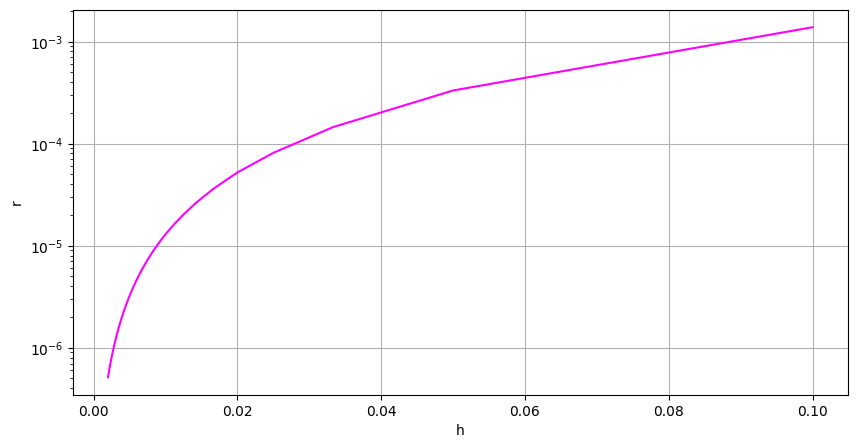

In [727]:
x = []
for i in nArr:
    x.append(np.linspace(a, b, i))

r = []
for i in range(hArr.size):
    r.append(np.sqrt(hArr[i])*np.linalg.norm(u(x[i])[1:-1] - alpha[i], ord=2))

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(hArr, r, color='fuchsia')
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('r')
plt.grid()

#### Установите эксперементально порядок сходимости метода по $h$.

In [728]:
for i in range(4):
    print(f'Шаг метода: {hArr[i]}, погрешность метода: {r[i]}')

Шаг метода: 0.1, погрешность метода: 0.0013804672508553374
Шаг метода: 0.05, погрешность метода: 0.00033124482553856585
Шаг метода: 0.03333333333333333, погрешность метода: 0.00014527784670588195
Шаг метода: 0.025, погрешность метода: 8.118373940806188e-05


При уменьшении шага с $h=0.05$ до $h=0.025$ (в два раза) погрешность уменьшилась в $\displaystyle \frac{0.00033}{8.118 \cdot 10^{-5}} \approx 4 \implies$ второй порядок сходимости по $h$

#### Формула Симпсона для интегрирования

In [729]:
alphaSimp = []
for i in range(nArr.size):
  A, c = createMtrVect(nArr[i], meth='simp')
  alphaSimp.append(CG(A, c))

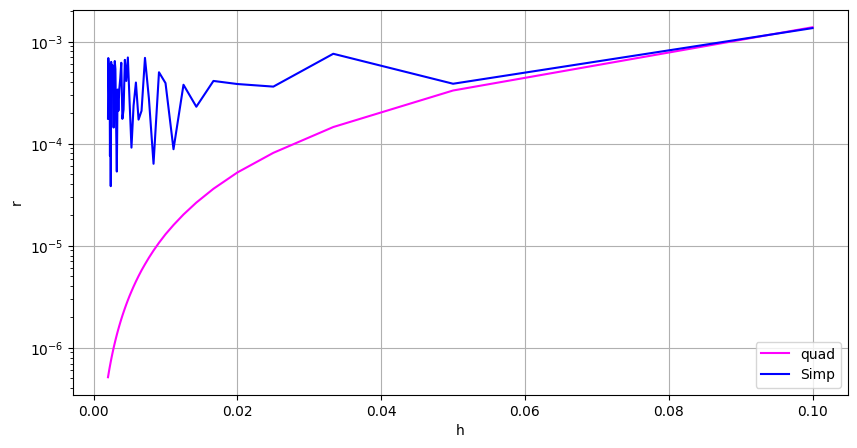

In [730]:
rSimp = []
for i in range(nArr.size):
    rSimp.append(np.sqrt(hArr[i])*np.linalg.norm(u(x[i])[1:-1] - alphaSimp[i], ord=2))

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.plot(hArr, r, color='fuchsia', label='quad')
axs.plot(hArr, rSimp, color='blue', label='Simp')
plt.legend()
plt.yscale('log')
plt.xlabel('h')
plt.ylabel('r')
plt.grid()

Видим, что при замене формулы интегрирования на формулу Симпсона погрешность с определённого значения $h$ начинате колебаться около одно значения